In [1]:
import os
import cv2
import itertools
import multiprocessing
import concurrent.futures
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import Xception
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection  import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
path = '/ISIC_datasets/ISIC_2018/'

In [4]:
df = pd.read_csv(path + 'ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

In [5]:
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'BKL': 'Benign keratosis',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesion',
}
classes = [value for key, value in lesion_type_dict.items()]
label_dict = dict([(column, i) for i, column in enumerate(df.columns[1:])])
lesion_tag_dict = dict([(i, column) for i, column in enumerate(df.columns[1:])])

In [6]:
lesion_tag_dict

{0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AKIEC', 4: 'BKL', 5: 'DF', 6: 'VASC'}

In [7]:
CorrectedLabels = df[df.columns[1:]].to_numpy()
CorrectedLabels = np.argmax(CorrectedLabels, axis=1)
df['label'] = CorrectedLabels
df.head()

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC  label
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0      1
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0      0

In [8]:
df.drop(df.columns[1:8], axis=1, inplace=True)
df.head()

image  label
0  ISIC_0024306      1
1  ISIC_0024307      1
2  ISIC_0024308      1
3  ISIC_0024309      1
4  ISIC_0024310      0

In [9]:
df['disease'] = (df['label'].map(lesion_tag_dict.get)).map(lesion_type_dict.get)
df.head()

image  label            disease
0  ISIC_0024306      1  Melanocytic nevus
1  ISIC_0024307      1  Melanocytic nevus
2  ISIC_0024308      1  Melanocytic nevus
3  ISIC_0024309      1  Melanocytic nevus
4  ISIC_0024310      0           Melanoma

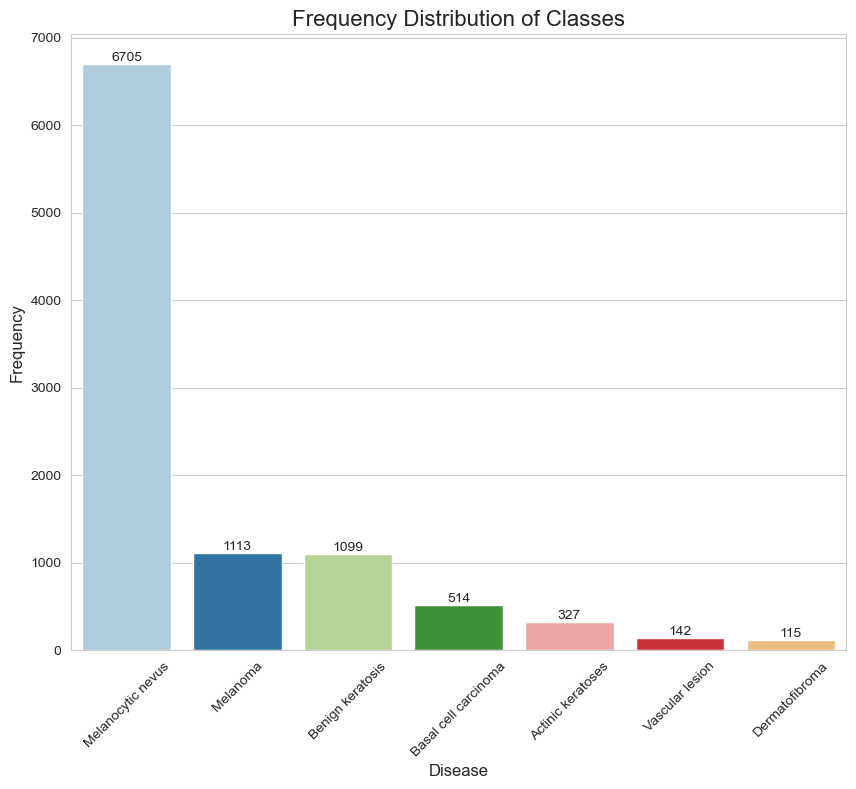

In [10]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(10,8))
ax = sns.countplot(x = 'disease', data = df, order = df['disease'].value_counts().index, palette='Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Frequency Distribution of Classes', size=16)
plt.xticks(rotation=45)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.show()

In [11]:
image_size = 227
max_workers = multiprocessing.cpu_count()

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))

with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    image_arrays = list(executor.map(resize_image_array, (path + 'train/' + df['image'] + '.jpg').tolist()))

df['image_array'] = image_arrays
del image_arrays
df.head()

image  label            disease  \
0  ISIC_0024306      1  Melanocytic nevus   
1  ISIC_0024307      1  Melanocytic nevus   
2  ISIC_0024308      1  Melanocytic nevus   
3  ISIC_0024309      1  Melanocytic nevus   
4  ISIC_0024310      0           Melanoma   

                                         image_array  
0  [[[224, 129, 129], [226, 131, 131], [229, 131,...  
1  [[[215, 123, 134], [217, 123, 134], [219, 122,...  
2  [[[246, 172, 181], [247, 174, 181], [246, 172,...  
3  [[[208, 119, 134], [206, 120, 133], [207, 122,...  
4  [[[71, 34, 38], [72, 32, 39], [71, 32, 38], [6...

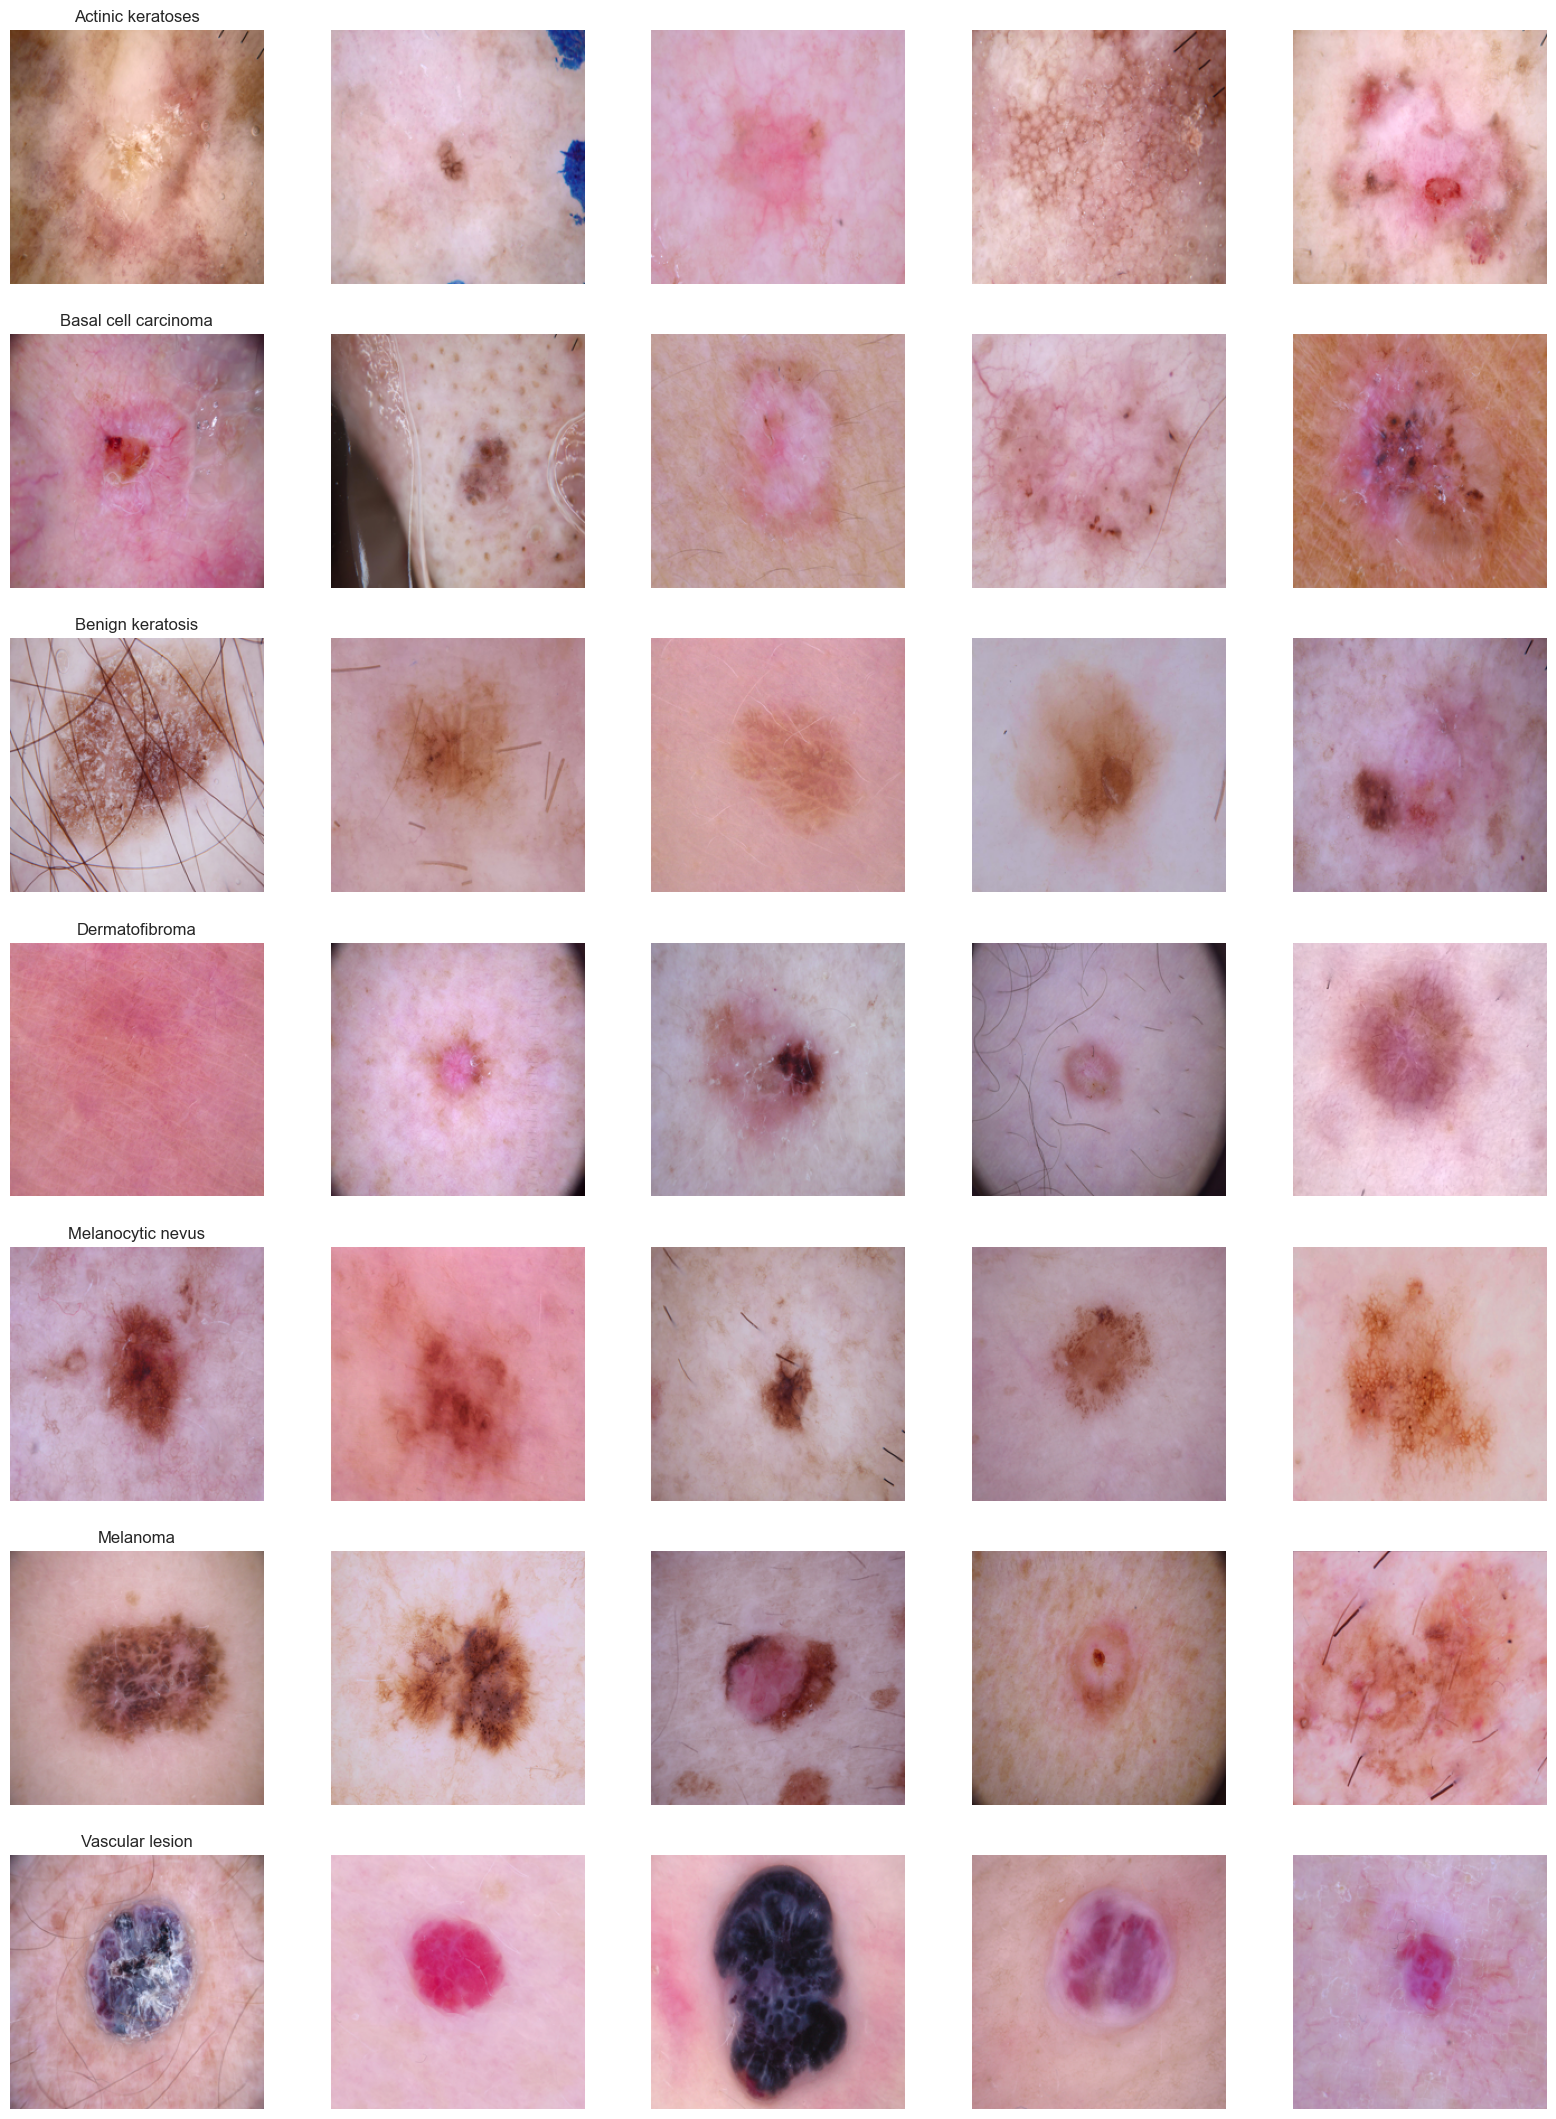

In [12]:
n_samples = 5
n_diseases = len(lesion_type_dict)
fig, m_axs = plt.subplots(n_diseases, n_samples, figsize = (4*n_samples, 3*9))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['disease']).groupby('disease')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image_array'])
        c_ax.axis('off')

In [13]:
X = df.drop(columns=['image','label','disease'],axis=1)
X = X['image_array'].to_list()
y = df['label'].to_list()

In [14]:
del df

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
del X
del y

In [16]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1111727505, random_state=42) # 80% 10% 10%

In [17]:
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [18]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))
y_val = to_categorical(y_val, num_classes=len(classes))

In [19]:
x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_val.shape, y_test.shape

((8010, 227, 227, 3),
 (1002, 227, 227, 3),
 (1003, 227, 227, 3),
 (8010, 7),
 (1003, 7),
 (1002, 7))

In [20]:
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11, 11), 
                        strides=(4, 4), activation="relu", 
                        input_shape=(227, 227, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides= (2, 2)))
model.add(Conv2D(filters=256, kernel_size=(5, 5), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), 
                        strides=(1, 1), activation="relu", 
                        padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))
#model.add(Dense(1000, activation="relu"))
model.add(Dense(len(classes), activation="softmax"))

model.compile(loss=CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [21]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

batch_size = 32
train_gen = DataGenerator(x_train, y_train, batch_size)
val_gen = DataGenerator(x_val, y_val, batch_size)

In [22]:
history = model.fit(train_gen, validation_data=val_gen, epochs = 50)

Epoch 1/50
251/251 [==============================] - 16s 40ms/step - loss: 1.4495 - accuracy: 0.6122 - val_loss: 2.1295 - val_accuracy: 0.1176
Epoch 2/50
251/251 [==============================] - 9s 37ms/step - loss: 1.0981 - accuracy: 0.6577 - val_loss: 0.8530 - val_accuracy: 0.6939
Epoch 3/50
251/251 [==============================] - 9s 37ms/step - loss: 0.9615 - accuracy: 0.6724 - val_loss: 1.3446 - val_accuracy: 0.6740
Epoch 4/50
251/251 [==============================] - 9s 37ms/step - loss: 0.8854 - accuracy: 0.6904 - val_loss: 0.8356 - val_accuracy: 0.7139
Epoch 5/50
251/251 [==============================] - 9s 37ms/step - loss: 0.8407 - accuracy: 0.7037 - val_loss: 1.0243 - val_accuracy: 0.6879
Epoch 6/50
251/251 [==============================] - 9s 37ms/step - loss: 0.8101 - accuracy: 0.7089 - val_loss: 1.0496 - val_accuracy: 0.6919
Epoch 7/50
251/251 [==============================] - 9s 37ms/step - loss: 0.7651 - accuracy: 0.7226 - val_loss: 1.9107 - val_accuracy: 0.241

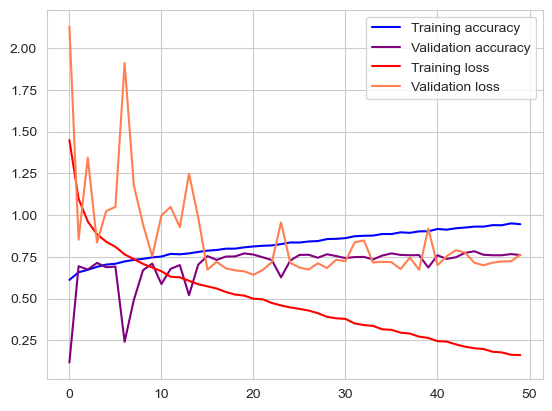

In [23]:
plt.plot(history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation accuracy', color='purple')
plt.plot(history.history['loss'], label='Training loss', color = 'red')
plt.plot(history.history['val_loss'], label='Validation loss', color='coral')
plt.legend()
plt.show()

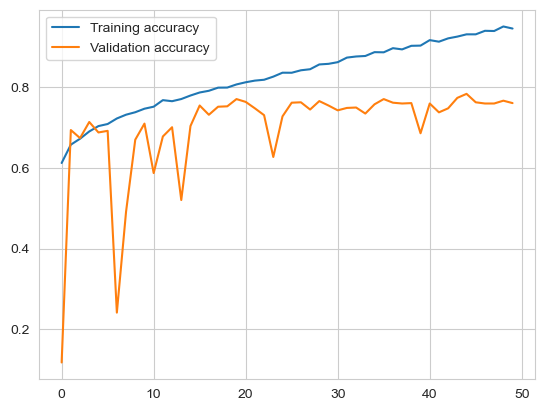

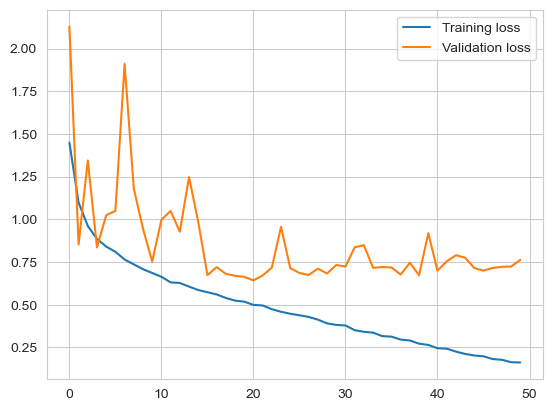

In [24]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [25]:
def get_svm_predictions(x_train_features, x_test_features, y_train, y_test):
    x_train_features  = x_train_features.reshape(x_train_features.shape[0], -1)
    x_test_features = x_test_features.reshape(x_test_features.shape[0], -1)

    clf = svm.SVC(kernel="rbf")
    clf.fit(x_train_features, np.argmax(y_train, axis=1))
    return clf.predict(x_test_features)

def plot_confusion_matrix(y_test, y_pred, cmap = plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=np.argmax(y_test, axis=1), cmap=cmap)
    plt.xticks(np.arange(len(classes)), lesion_type_dict, rotation=45)
    plt.yticks(np.arange(len(classes)), lesion_type_dict)
    plt.grid(False)
    plt.show()
    
def plot_classification_report(y_test, y_pred, target_names):
    print(classification_report(y_pred=y_pred, y_true= np.argmax(y_test, axis=1), target_names=target_names))

def create_and_plot_confusion_matrix(y_test, y_pred):
    def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        #plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, lesion_type_dict, rotation=45)
        plt.yticks(tick_marks, lesion_type_dict)

        if normalize:
            cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals = 2)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.grid(False)
        plt.show()
    cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    plot_cm(cm, normalize=False, classes = classes)
    
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

def print_multiclass_cm_metrics(y_test, y_pred, visualize = False, printable = True, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        if printable:
            print(f'Current Label: {lesion_type_dict[lesion_tag_dict[i]]}')
        if visualize:
            print(mcm[i])
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(classes))
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        plt.xticks(x, lesion_type_dict)
        plt.legend(loc='lower left')
        plt.show()

def get_metrics(x, y):
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred, axis=1)
    plot_confusion_matrix(y_test=y, y_pred=y_pred)
    plot_classification_report(y_pred=y_pred, y_test=y, target_names=classes)
    print_multiclass_cm_metrics(y_test=y,y_pred=y_pred)

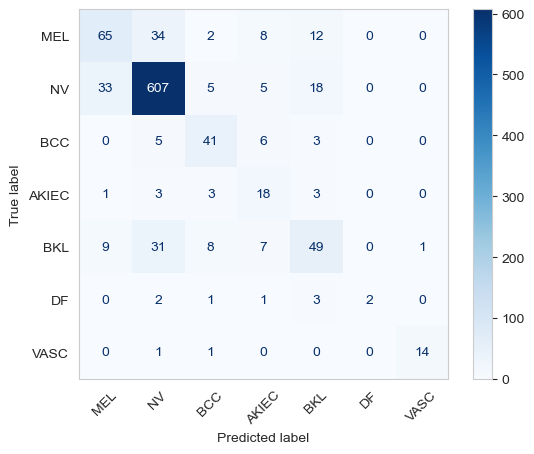

                      precision    recall  f1-score   support

            Melanoma       0.60      0.54      0.57       121
   Melanocytic nevus       0.89      0.91      0.90       668
Basal cell carcinoma       0.67      0.75      0.71        55
   Actinic keratoses       0.40      0.64      0.49        28
    Benign keratosis       0.56      0.47      0.51       105
      Dermatofibroma       1.00      0.22      0.36         9
     Vascular lesion       0.93      0.88      0.90        16

            accuracy                           0.79      1002
           macro avg       0.72      0.63      0.63      1002
        weighted avg       0.80      0.79      0.79      1002

Current Label: Melanoma
	Precision: 0.6018518518518519
	Sensitivity: 0.5371900826446281
	Specificity: 0.9511918274687855
	Accuracy: 0.9011976047904192

Current Label: Melanocytic nevus
	Precision: 0.8887262079062958
	Sensitivity: 0.9086826347305389
	Specificity: 0.7724550898203593
	Accuracy: 0.8632734530938124

Cu

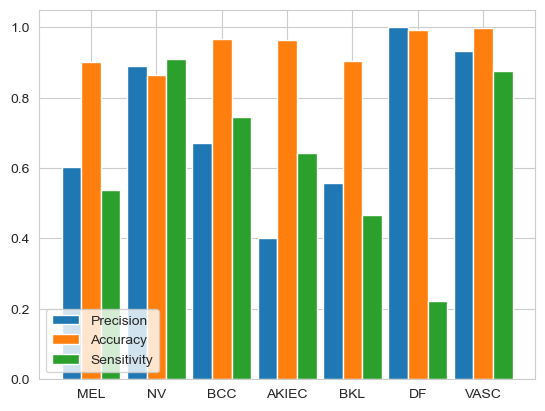

In [26]:
get_metrics(x_test, y_test)

In [27]:
model.save('model_NAYB.h5')
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)
np.save("x_test", x_test)
np.save("y_test", y_test)